In [ ]:
pip install pydicom nibabel numpy torch torchvision segmentation-models-pytorch scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=e3e751607ed93d5d014afb6bd717169509a1d3cf48e1e40d40142e130c0f9d2b
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=537915148272de606bf9422fc8b308b0cabe1b253488a171c064687d6c318c10
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pyt

<ipython-input-3-327da7e39db3>:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).unsqueeze(0).to(device)
/usr/local/lib/python3.10/dist-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch 1/25, Training IoU: 0.41593018968534823
Epoch 1/25, Validation IoU: 0.6571955919265747
Epoch 2/25, Training IoU: 0.7027288377285004
Epoch 2/25, Validation IoU: 0.729192528128624
Epoch 3/25, Training IoU: 0.7558252885937691
Epoch 3/25, Validation IoU: 0.7640852898359298
Epoch 4/25, Training IoU: 0.8022418841719627
Epoch 4/25, Validation IoU: 0.8224015593528747
Epoch 5/25, Training IoU: 0.8546340544434154
Epoch 5/25, Validation IoU: 0.8457376569509506
Epoch 6/25, Training IoU: 0.8742746009546167
Epoch 6/25, Validation IoU: 0.8579506158828736
Epoch 7/25, Training IoU: 0.8832804556278622
Epoch 7/25, Validation IoU: 0.860163414478302
Epoch 8/25, Training IoU: 0.8915035693961031
Epoch 8/25, Validation IoU: 0.863113397359848
Epoch 9/25, Training IoU: 0.8976038764504826
Epoch 9/25, Validation IoU: 0.869978415966034
Epoch 10/25, Training IoU: 0.9032687470316887
Epoch 10/25, Validation IoU: 0.8744566917419434
Epoch 11/25, Training IoU: 0.9106994315105326
Epoch 11/25, Validation IoU: 0.8754

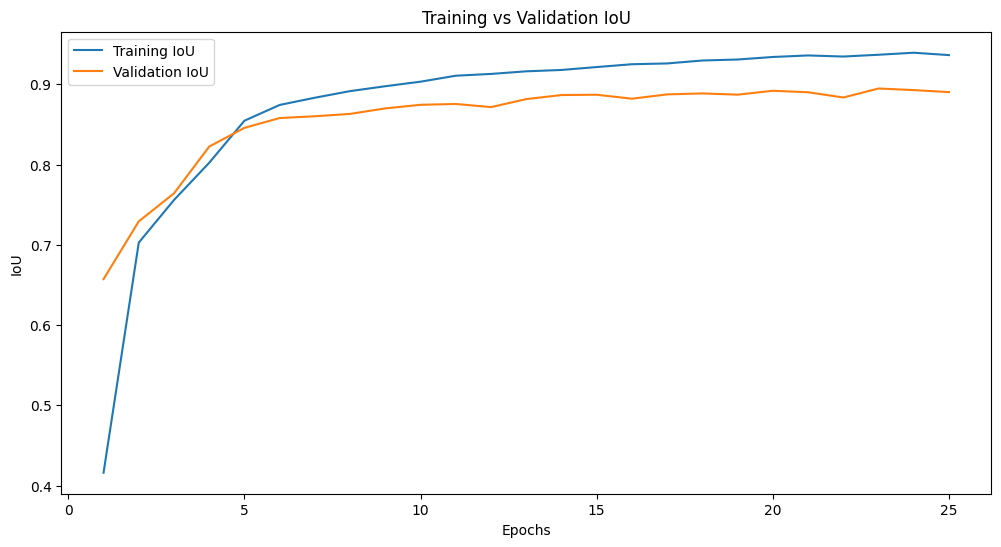

In [ ]:
import os
import numpy as np
import pydicom
import nibabel as nib
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import random
import segmentation_models_pytorch as smp

def compute_iou(pred, target, num_classes):
    pred = (pred > 0.5).float()
    intersection = torch.sum(pred * target, dim=(1, 2))
    union = torch.sum((pred + target) > 0, dim=(1, 2))
    iou = (intersection + 1e-10) / (union + 1e-10)
    return torch.mean(iou).item()

class MulticlassHipSegmentationDataset(Dataset):
    def __init__(self, img_root, mask_root, image_files, mask_files, num_classes, transforms=None, preprocessing=None):
        self.img_root = img_root
        self.mask_root = mask_root
        self.img_files = image_files
        self.mask_files = mask_files
        self.num_classes = num_classes
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        dicom_image = pydicom.dcmread(os.path.join(self.img_root, self.img_files[idx]))
        image = dicom_image.pixel_array.astype(np.float32)
        annotation = nib.load(os.path.join(self.mask_root, self.mask_files[idx]))
        annotation_data = annotation.get_fdata()
        if len(annotation_data.shape) == 3:
            annotation_data = annotation_data[:, :, 0]
        annotation_data = np.rot90(annotation_data, k=7)
        if annotation_data.ndim > 2 and annotation_data.shape[-1] != 1:
            raise ValueError('Mask has multiple channels')

        if image.shape != annotation_data.shape:
            zoom_factors = np.array(image.shape) / np.array(annotation_data.shape)
            annotation_data = zoom(annotation_data, zoom_factors, order=0)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=annotation_data)
            image = transformed["image"]
            annotation_data = transformed["mask"]

        annotation_data_onehot = self.one_hot_encode(annotation_data)

        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=annotation_data_onehot)
            image = transformed["image"]
            annotation_data_onehot = transformed["mask"]

        return image, annotation_data_onehot

    def one_hot_encode(self, mask):
        one_hot_mask = np.zeros((self.num_classes, *mask.shape), dtype=np.float32)
        for class_idx in range(self.num_classes):
            one_hot_mask[class_idx][mask == class_idx] = 1.0
        return one_hot_mask


img_root = 'JHIR_Hip_Knee_Datasets/Hip/Images'
mask_root = 'JHIR_Hip_Knee_Datasets/Hip/Annotations'

image_files = sorted(os.listdir(img_root))
mask_files = sorted(os.listdir(mask_root))
paired_files = list(zip(image_files, mask_files))
random.shuffle(paired_files)

train_size = int(0.7 * len(paired_files))
valid_size = int(0.1 * len(paired_files))
test_size = len(paired_files) - train_size - valid_size

train_pairs = paired_files[:train_size]
valid_pairs = paired_files[train_size:train_size + valid_size]
test_pairs = paired_files[train_size + valid_size:]

num_classes = 7

augmentations = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
], is_check_shapes=False)

model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=1,
    classes=num_classes,
)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.BCEWithLogitsLoss()
num_epochs = 25
train_ious = []
valid_ious = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


train_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in train_pairs], [p[1] for p in train_pairs], num_classes, transforms=augmentations)
valid_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in valid_pairs], [p[1] for p in valid_pairs], num_classes, transforms=augmentations)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=4, shuffle=False, num_workers=2)

for epoch in range(num_epochs):

    train_iou_values = []
    for pair in train_pairs:
        image_name, mask_name = pair
        image, mask = train_set.__getitem__(train_set.img_files.index(image_name))
        image = torch.tensor(image).unsqueeze(0).to(device)
        mask = torch.tensor(mask).unsqueeze(0).to(device)
        output = model(image)
        iou = compute_iou((output.sigmoid() > 0.5).float(), mask, num_classes)
        train_iou_values.append((image_name, mask_name, iou))



    train_iou_values = sorted(train_iou_values, key=lambda x: x[2], reverse=True)
    train_pairs = [(pair[0], pair[1]) for pair in train_iou_values]

    train_set = MulticlassHipSegmentationDataset(img_root, mask_root, [p[0] for p in train_pairs], [p[1] for p in train_pairs], num_classes, transforms=augmentations)
    train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)

    model.train()
    train_epoch_iou = 0

    for batch in train_loader:
        images, masks = batch
        optimizer.zero_grad()
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        batch_iou = compute_iou((outputs.sigmoid() > 0.5).float(), masks, num_classes)
        train_epoch_iou += batch_iou

    train_epoch_iou /= len(train_loader)
    train_ious.append(train_epoch_iou)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training IoU: {train_epoch_iou}")

    model.eval()
    valid_epoch_iou = 0

    with torch.no_grad():
        for batch in valid_loader:
            images, masks = batch
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            batch_iou = compute_iou((outputs.sigmoid() > 0.5).float(), masks, num_classes)

            valid_epoch_iou += batch_iou

    valid_epoch_iou /= len(valid_loader)
    valid_ious.append(valid_epoch_iou)
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation IoU: {valid_epoch_iou}")

torch.save(model.state_dict(), 'unet_resnet18_multiclass_model_weightscl.pth')

plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_ious, label='Training IoU')
plt.plot(range(1, num_epochs + 1), valid_ious, label='Validation IoU')
plt.title('Training vs Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


In [ ]:
test_loader = create_test_loader(test_pairs, augmentations, num_classes)
test_ious = []
model.eval()

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        batch_iou = compute_iou((outputs > 0.5).float(), masks, num_classes)
        test_ious.append(batch_iou)

test_mean_iou = np.mean(test_ious)

print(f"Test Mean IoU: {test_mean_iou}")


Test Mean IoU: 0.9389850899481005


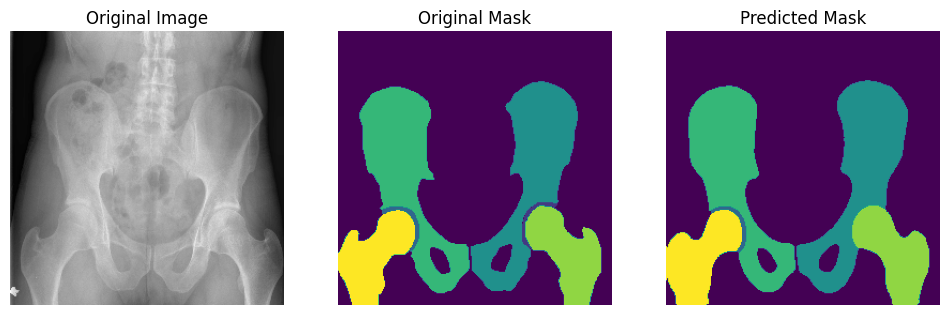

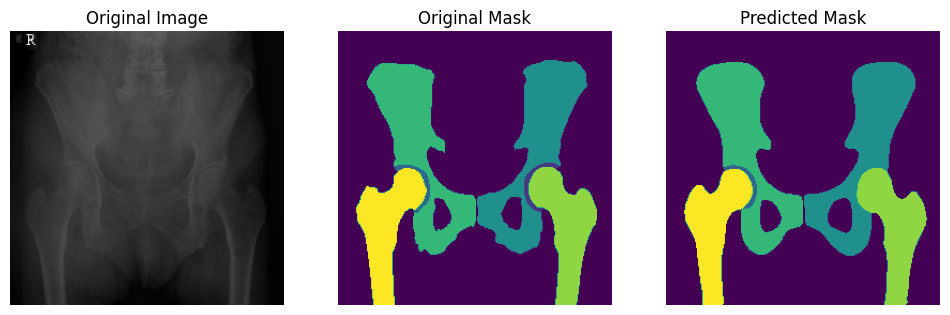

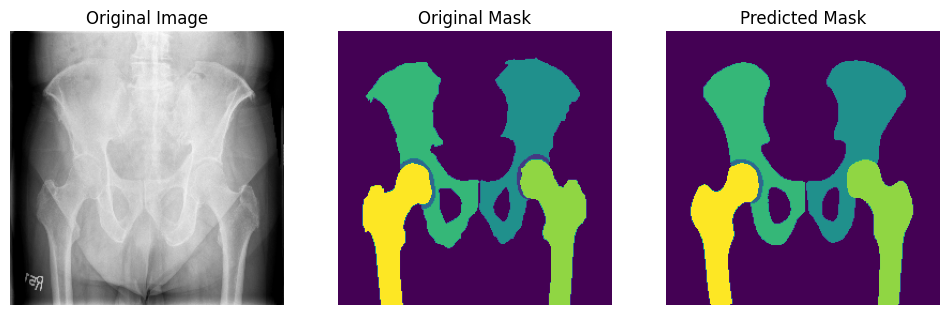

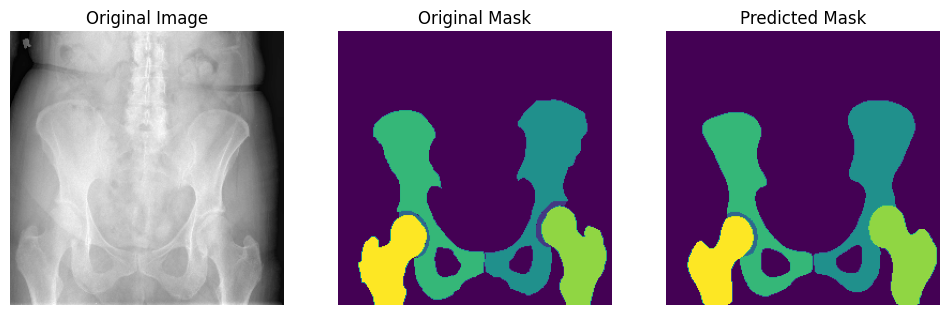

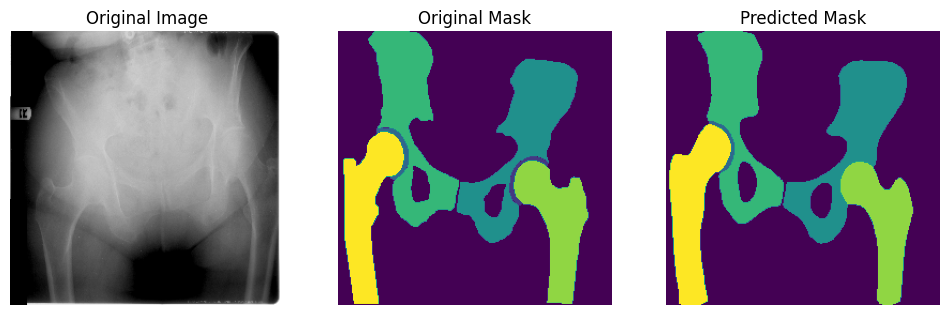

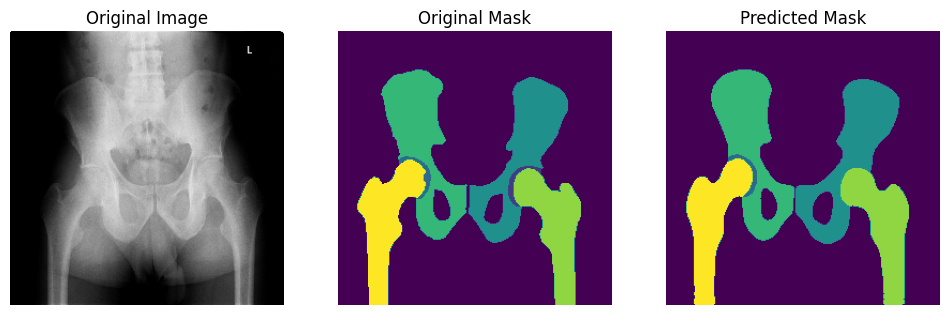

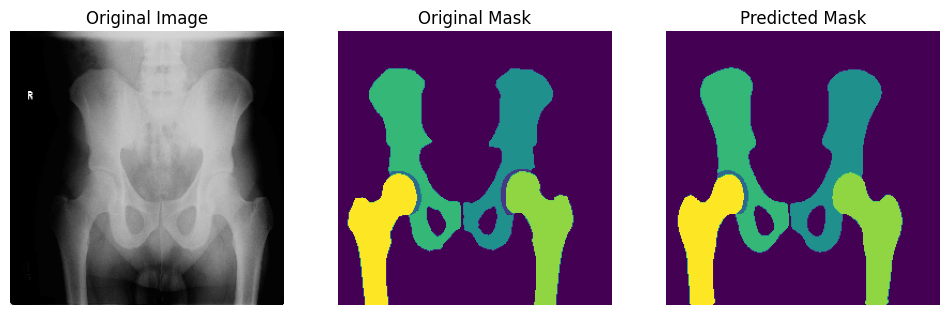

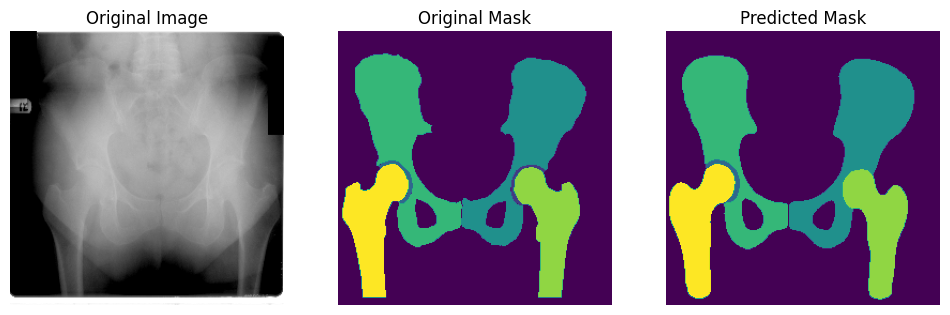

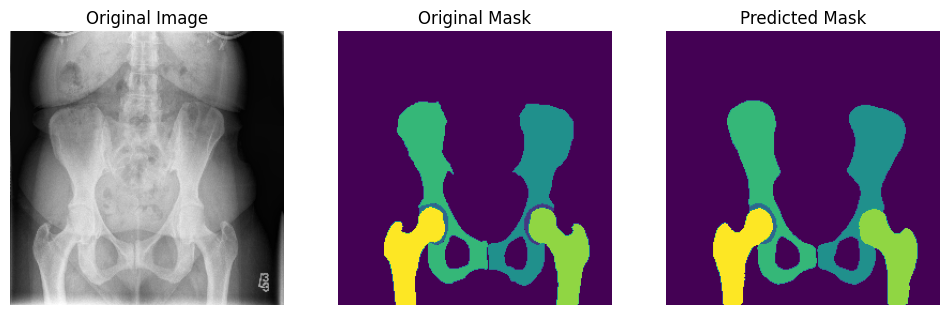

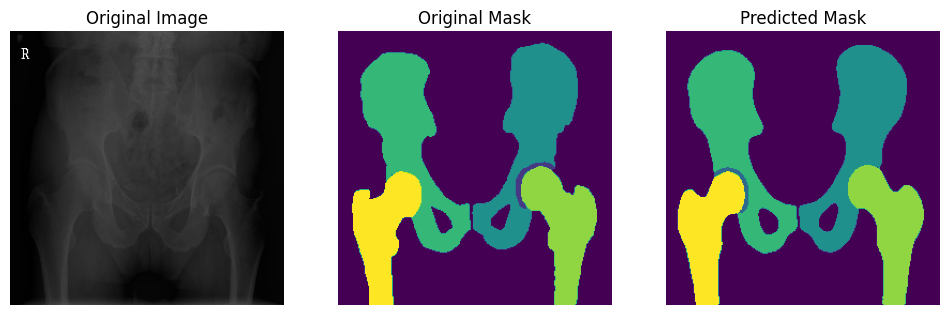

In [ ]:
import os
import numpy as np
import pydicom
import nibabel as nib
import torch
import random
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_pil_image
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2




def compute_iou(pred, target, num_classes):
    pred = (pred > 0.5).float()
    intersection = torch.sum(pred * target, dim=(1, 2))
    union = torch.sum((pred + target) > 0, dim=(1, 2))
    iou = (intersection + 1e-10) / (union + 1e-10)
    return torch.mean(iou).item()


class MulticlassHipSegmentationDataset(Dataset):
    def __init__(self, img_root, mask_root, image_files, mask_files, num_classes, transforms=None, preprocessing=None):
        self.img_root = img_root
        self.mask_root = mask_root
        self.img_files = image_files
        self.mask_files = mask_files
        self.num_classes = num_classes
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        dicom_image = pydicom.dcmread(os.path.join(self.img_root, self.img_files[idx]))
        image = dicom_image.pixel_array.astype(np.float32)
        annotation = nib.load(os.path.join(self.mask_root, self.mask_files[idx]))
        annotation_data = annotation.get_fdata()
        if len(annotation_data.shape) == 3:
            annotation_data = annotation_data[:, :, 0]
        annotation_data = np.rot90(annotation_data, k=7)
        if annotation_data.ndim > 2 and annotation_data.shape[-1] != 1:
            raise ValueError('Mask has multiple channels')

        if image.shape != annotation_data.shape:
            zoom_factors = np.array(image.shape) / np.array(annotation_data.shape)
            annotation_data = zoom(annotation_data, zoom_factors, order=0)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=annotation_data)
            image = transformed["image"]
            annotation_data = transformed["mask"]

        annotation_data_onehot = self.one_hot_encode(annotation_data)

        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=annotation_data_onehot)
            image = transformed["image"]
            annotation_data_onehot = transformed["mask"]

        return image, annotation_data_onehot

    def one_hot_encode(self, mask):
        one_hot_mask = np.zeros((self.num_classes, *mask.shape), dtype=np.float32)
        for class_idx in range(self.num_classes):
            one_hot_mask[class_idx][mask == class_idx] = 1.0
        return one_hot_mask

image_files = sorted(os.listdir(img_root))
mask_files = sorted(os.listdir(mask_root))

paired_files = list(zip(image_files, mask_files))

random.shuffle(paired_files)

train_size = int(0.7 * len(paired_files))
valid_size = int(0.1 * len(paired_files))
test_size = len(paired_files) - train_size - valid_size

train_pairs = paired_files[:train_size]
valid_pairs = paired_files[train_size:train_size + valid_size]
test_pairs = paired_files[train_size + valid_size:]

augmentations = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2(),
], is_check_shapes=False)

num_classes = 7
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights=None,
    in_channels=1,
    classes=num_classes,
)

saved_model_path = 'unet_resnet18_multiclass_model_weightscl.pth'
checkpoint = torch.load(saved_model_path)
model.load_state_dict(checkpoint)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def create_test_loader(test_pairs, augmentations, num_classes):
    test_set = MulticlassHipSegmentationDataset(
        img_root,
        mask_root,
        [p[0] for p in test_pairs],
        [p[1] for p in test_pairs],
        num_classes,
        transforms=augmentations
    )
    test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
    return test_loader

def visualize_single_sample(images, masks, model):
    model.eval()
    with torch.no_grad():
        images = images.squeeze(0)
        masks = masks.squeeze(0)
        outputs = model(images.unsqueeze(0))
        original_mask = torch.argmax(masks, dim=0).cpu().numpy()
        predicted_mask = torch.argmax(outputs.squeeze(0), dim=0).cpu().numpy()
        image = images.permute(1, 2, 0).cpu().numpy()

        if image.shape[-1] == 1:
            image = image.squeeze(-1)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(original_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)
        plt.title('Original Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask, cmap='viridis', vmin=0, vmax=num_classes - 1)
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()


random_10_pairs = random.sample(test_pairs, 10)

random_10_loader = create_test_loader(random_10_pairs, augmentations, num_classes)

for images, masks in random_10_loader:
    visualize_single_sample(images, masks, model)
